Regresion Logistica

Juan David Meza
Grupo 1704

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
heart = pd.read_csv('heart_cleveland_upload.csv')

In [5]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [7]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [9]:
heart.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

In [11]:
number_cols = heart.select_dtypes(include=['float64', 'int64']).columns
print(f"Numeric Columns : {number_cols}")
categorical_cols = heart.select_dtypes(include=['object','category']).columns
print(f"Categorical Columns : {categorical_cols}")

Numeric Columns : Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')
Categorical Columns : Index([], dtype='object')


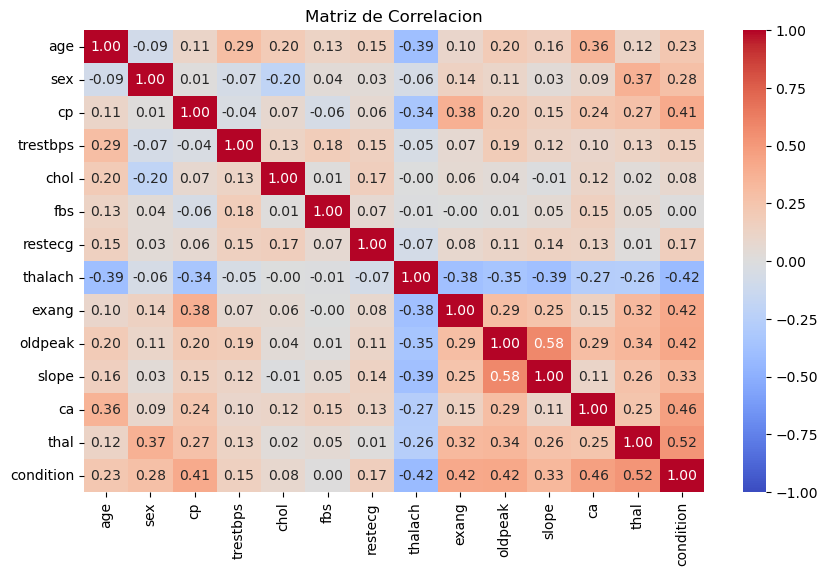

In [13]:
num_cols = len(number_cols)
corr_matrix = {col : {col : 0 for col in number_cols} for col in number_cols}

for i in range(num_cols):
    for j in range(i, num_cols):
        col1 = number_cols[i]
        col2 = number_cols[j]

        mean1 = heart[col1].mean()
        mean2 = heart[col2].mean()

        covariance = ((heart[col1] - mean1) * (heart[col2] - mean2)).mean()

        std_dev1 = heart[col1].std()
        std_dev2 = heart[col2].std()

        correlation = round(covariance / (std_dev1 * std_dev2), 2)

        corr_matrix[col1][col2] = correlation
        corr_matrix[col2][col1] = correlation

#print(f"Correlation Matrix : {corr_matrix}")

#Plotting Correlation Matrix Heatmap
corr_matrix2 = heart.select_dtypes(include = ['float64', 'int64']).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix2, annot = True, fmt = '.2f', cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0)
plt.title("Matriz de Correlacion")
plt.show()

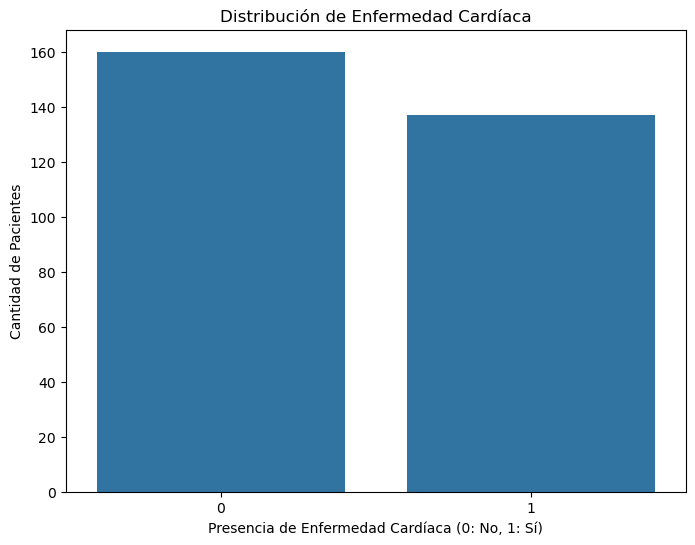

In [15]:
target_column = 'condition'
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(data=heart, x=target_column)
plt.title('Distribución de Enfermedad Cardíaca')
plt.xlabel('Presencia de Enfermedad Cardíaca (0: No, 1: Sí)')
plt.ylabel('Cantidad de Pacientes')
plt.show()


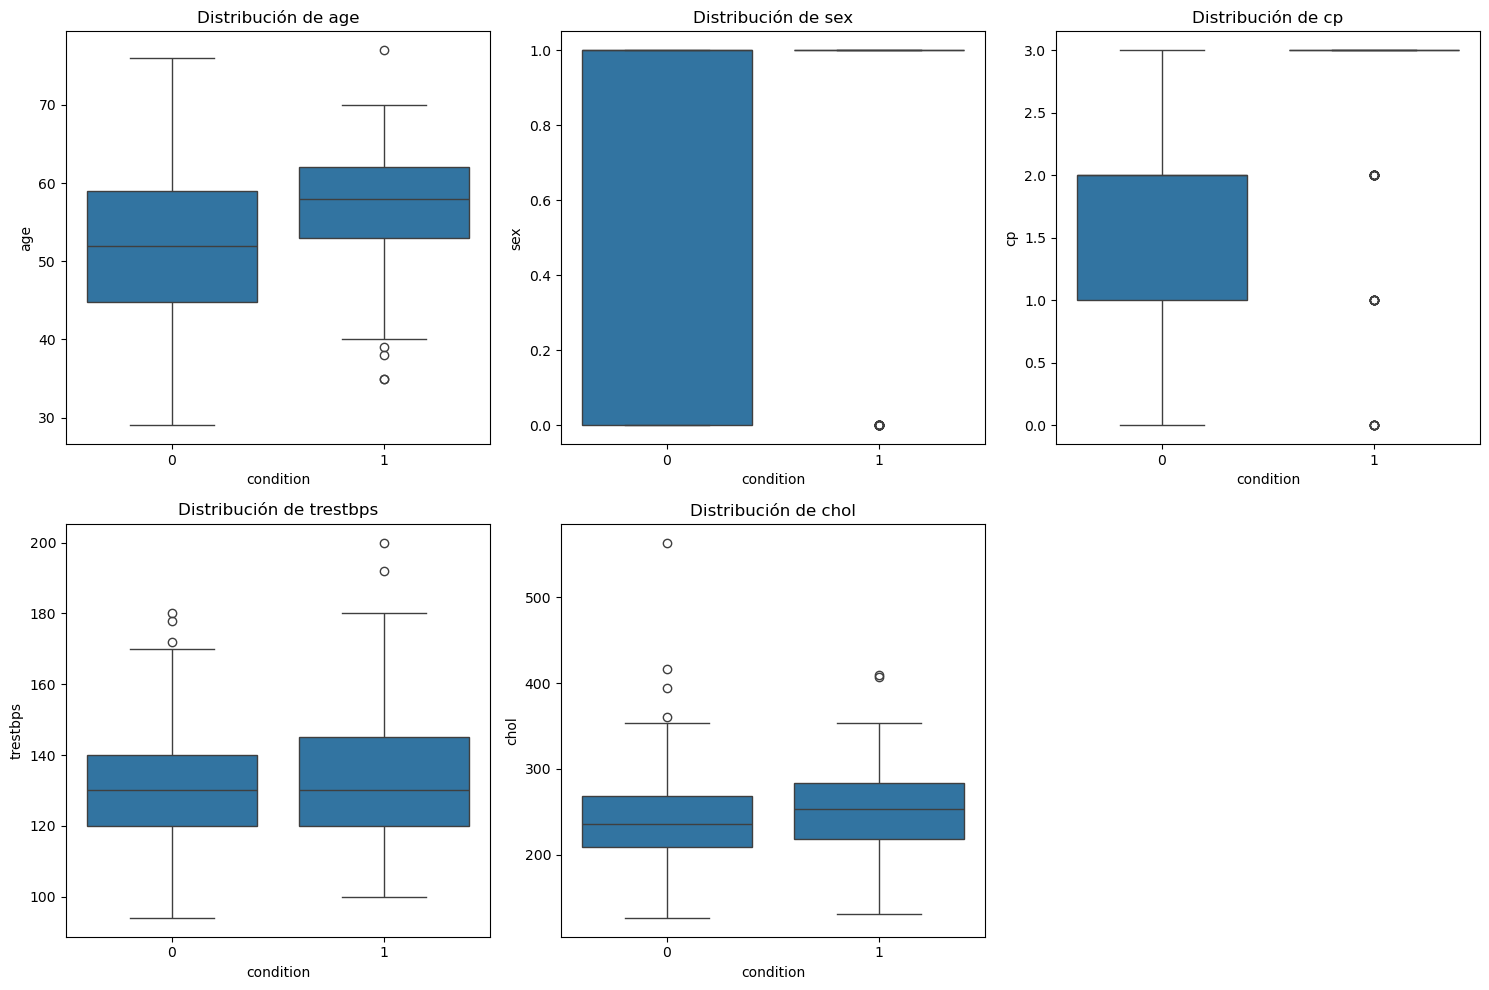

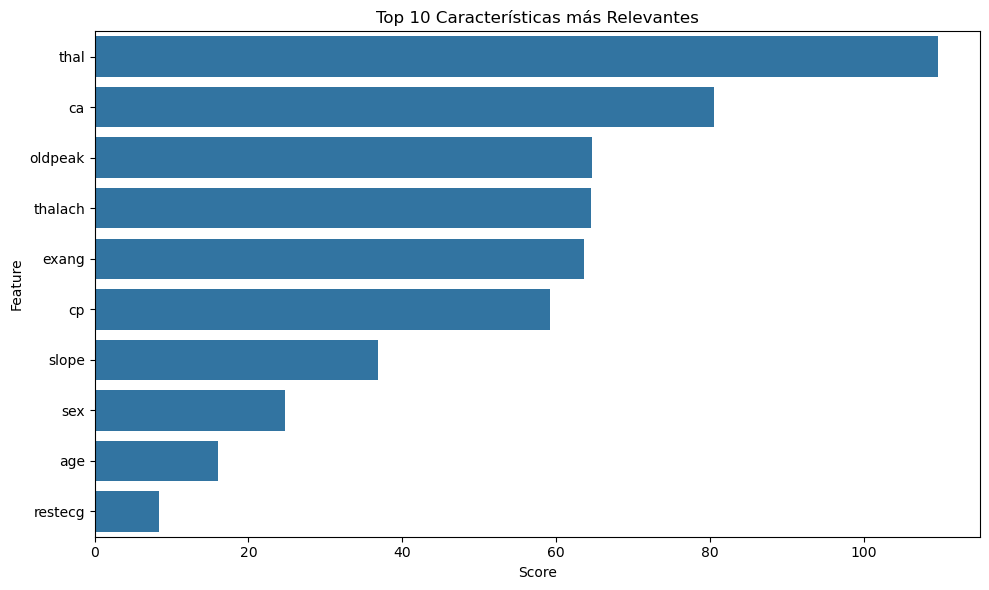

In [19]:
def explore_data(heart, target_column):
    # Variables numéricas
    numerical_cols = heart.select_dtypes(include=['float64', 'int64']).columns
    numerical_cols = [col for col in numerical_cols if col != target_column][:5]  # Limitamos a 5 variables
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=target_column, y=col, data=heart)
        plt.title(f'Distribución de {col}')
    plt.tight_layout()
    plt.show()
    
    return heart, target_column

def preprocess_data(heart, target_column):
    X = heart.drop(target_column, axis=1)
    y = heart[target_column]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

def select_features(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    
    scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=scores.head(k), x='Score', y='Feature')
    plt.title('Top {} Características más Relevantes'.format(k))
    plt.tight_layout()
    plt.show()
    
    return X_selected, selected_features

# Ejecutar el análisis exploratorio
heart, target_column = explore_data(heart, target_column)

# Preprocesar los datos
X, y = preprocess_data(heart, target_column)

# Seleccionar características
X_selected, selected_features = select_features(X, y, k=10)

In [21]:
# Verificar y tratar valores faltantes
print(heart.isnull().sum())
heart.fillna(heart.mean(), inplace=True)  # Imputar con la media

# Eliminación de duplicados
heart.drop_duplicates(inplace=True)

# Escalado de características
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
heart[['age', 'chol', 'trestbps']] = scaler.fit_transform(heart[['age', 'chol', 'trestbps']])

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


In [23]:
# Seleccionar características y la variable objetivo
X = heart.drop('condition', axis=1)
y = heart['condition']

# Usar Random Forest para evaluar la importancia de las características
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

# Importancia de características
importance = model.feature_importances_
feature_names = X.columns

# Crear un DataFrame con características y su importancia
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

     Feature  Importance
12      thal    0.135583
11        ca    0.130674
7    thalach    0.122604
2         cp    0.121043
9    oldpeak    0.103026
0        age    0.090592
4       chol    0.078587
3   trestbps    0.068608
8      exang    0.045670
10     slope    0.041332
1        sex    0.032432
6    restecg    0.019904
5        fbs    0.009946


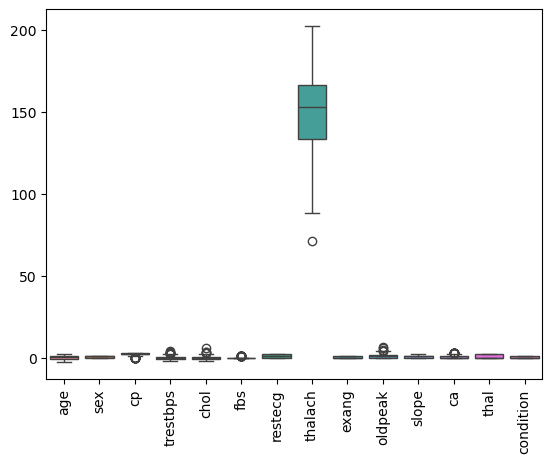

In [25]:
# Identificación de valores atípicos
sns.boxplot(data=heart)
plt.xticks(rotation=90)
plt.show()

In [27]:
# Verificar y tratar valores faltantes
print(heart.isnull().sum())
heart.fillna(heart.mean(), inplace=True)  # Imputar con la media

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


In [29]:
# Eliminación de duplicados
heart.drop_duplicates(inplace=True)

In [31]:
# Escalado de características
scaler = StandardScaler()
heart[['age', 'chol', 'trestbps']] = scaler.fit_transform(heart[['age', 'chol', 'trestbps']])

In [33]:
# 3. Selección de Características
X = heart.drop('condition', axis=1)
y = heart['condition']

model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [35]:
# Importancia de características
importance = model.feature_importances_
feature_names = X.columns

In [37]:
# Crear un DataFrame con características y su importancia
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

     Feature  Importance
12      thal    0.137845
11        ca    0.118178
2         cp    0.117883
7    thalach    0.114358
9    oldpeak    0.109045
0        age    0.093723
4       chol    0.077921
3   trestbps    0.077693
8      exang    0.047131
10     slope    0.045921
1        sex    0.030081
6    restecg    0.020774
5        fbs    0.009446


In [39]:
# 4. División del Dataset en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# 5. Entrenamiento del Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [43]:
# 6. Evaluación del Desempeño del Modelo
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.70      0.75      0.72        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



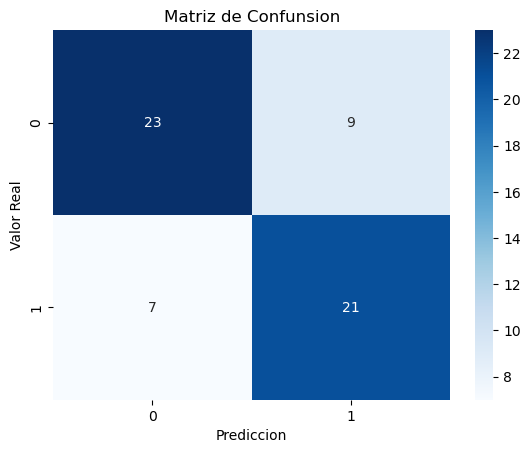

In [45]:
# Métricas de evaluación
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confunsion')
plt.xlabel('Prediccion')
plt.ylabel('Valor Real')
plt.show()

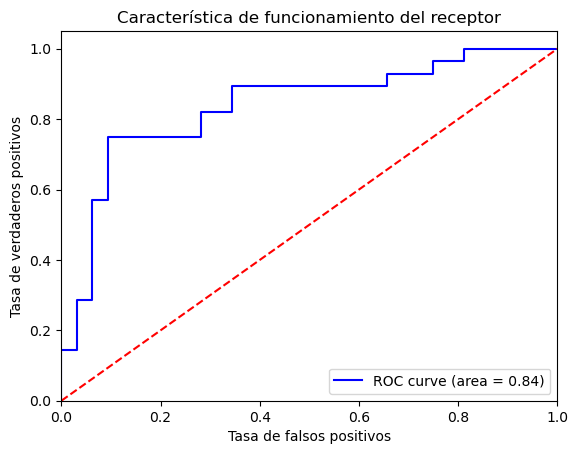

In [47]:
# 7. Graficar la curva ROC
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Característica de funcionamiento del receptor')
plt.legend(loc="lower right")
plt.show()

Interpretación y Análisis de los Resultados del Modelo de Regresión Logística

Evaluación por Clase:

Clase 0 (Sin Enfermedad Cardíaca):
Precisión (0.77): De todas las predicciones donde el modelo indicó que no había enfermedad cardíaca, el 77% fueron correctas.
Recall (0.72): De todos los casos reales sin enfermedad cardíaca, el modelo identificó correctamente el 72%.
F1-Score (0.74): La métrica F1 balancea la precisión y el recall, reflejando un desempeño sólido para esta clase.

Clase 1 (Con Enfermedad Cardíaca):
Precisión (0.70): De las predicciones que identificaron enfermedad cardíaca, el 70% fueron correctas.
Recall (0.75): De los pacientes con enfermedad cardíaca real, el modelo identificó correctamente el 75%.
F1-Score (0.72): Este puntaje indica que el modelo tiene una buena capacidad para identificar casos positivos de enfermedad cardíaca, aunque su precisión es menor que en la clase negativa.

Desempeño General:

Precisión Total (Accuracy: 0.73): El modelo clasifica correctamente el 73% de todos los casos, lo que refleja un rendimiento moderado.
Promedios Macro y Ponderado: Los promedios de precisión, recall y F1-score (ambos en 0.73) sugieren un rendimiento balanceado entre las clases, lo cual es positivo para problemas donde ambas clases (presencia y ausencia de enfermedad) son de interés.

In [ ]:
El modelo de regresión logística muestra un desempeño moderadamente fuerte en la predicción de la presencia de enfermedad cardíaca, logrando una precisión general de 73%. Los resultados son alentadores y sugieren que el modelo es útil para clasificar casos de enfermedad cardíaca